# Sign Language Fingerspelling Recognition
The goal of this project is to detect and translate American Sign Language (ASL) fingerspelling into text.

The dataset includes files with landmark information extracted from videos using the MediaPipe holistic model. These landmark files contain spatial coordinate data for different types of landmarks (such as face, left hand, pose, and right hand) in the form of x, y, and z coordinates. 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from pathlib import Path
import json

## Data EDA

In [3]:
BASE_DIR = '../input/asl-fingerspelling'

train = pd.read_csv(f'{BASE_DIR}/train.csv')
#supplemental_metadata = pd.read_csv(f'{BASE_DIR}/supplemental_metadata.csv')

In [4]:
train.shape

(67287, 5)

In [5]:
train.head() 

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816862427               0   
3  train_landmarks/5414471.parquet  5414471   1816909464               1   
4  train_landmarks/5414471.parquet  5414471   1816967051              63   

                phrase  
0         3 creekhouse  
1      scales/kuhaylah  
2       hentaihubs.com  
3  1383 william lanier  
4    988 franklin lane

In [6]:
train.query('phrase == "surprise az"')

path     file_id  sequence_id  \
9067    train_landmarks/349393104.parquet   349393104    894682073   
9750    train_landmarks/349393104.parquet   349393104    918130651   
11175   train_landmarks/425182931.parquet   425182931   1121952165   
11795   train_landmarks/425182931.parquet   425182931   1140531985   
13892   train_landmarks/474255203.parquet   474255203     53122870   
18468   train_landmarks/546816846.parquet   546816846   1436504564   
28678   train_landmarks/933868835.parquet   933868835    838563709   
32306  train_landmarks/1098899348.parquet  1098899348   1848989014   
34872  train_landmarks/1133664520.parquet  1133664520    560352351   
36556  train_landmarks/1255240050.parquet  1255240050    581413666   
37034  train_landmarks/1255240050.parquet  1255240050    595834010   
42662  train_landmarks/1405046009.parquet  1405046009    240058490   
45089  train_landmarks/1497621680.parquet  1497621680   1047290809   
46559  train_landmarks/1557244878.parquet  1557244878    331596218   
54849  train_landmarks/1865557033.parquet  1865557033   2123641268   
60427  train_landmarks/1969985709.parquet  1969985709   1595884623   
61648  train_landmarks/1997878546.parquet  1997878546    711000266   

       participant_id       phrase  
9067               20  surprise az  
9750              242  surprise az  
11175             102  surprise az  
11795             113  surprise az  
13892             254  surprise az  
18468              36  surprise az  
28678              72  surprise az  
32306              68  surprise az  
34872             254  surprise az  
36556             128  surprise az  
37034              59  surprise az  
42662              10  surprise az  
45089             230  surprise az  
46559             168  surprise az  
54849             203  surprise az  
60427             136  surprise az  
61648             161  surprise az

- There are a total of 68 unique values in the 'path' column.
- The unique values represent different data files in parquet format.
- The most common value, train_landmarks/5414471.parquet, appears 1000 times in the column.
- Most unique values (67 of 68) appear 1000 times, indicating that most data files have the same number of sign language records (sequences).
- However, there is a unique value, train_landmarks/450474571.parquet, which appears only 287 times, indicating that that particular file has fewer records of sign language sequences.

In [7]:
train['path'].value_counts()

train_landmarks/5414471.parquet       1000
train_landmarks/1405046009.parquet    1000
train_landmarks/1643479812.parquet    1000
train_landmarks/1562234637.parquet    1000
train_landmarks/1557244878.parquet    1000
                                      ... 
train_landmarks/933868835.parquet     1000
train_landmarks/939623093.parquet     1000
train_landmarks/1019715464.parquet    1000
train_landmarks/2118949241.parquet    1000
train_landmarks/450474571.parquet      287
Name: path, Length: 68, dtype: int64

This suggests that taking only one landmark as input, could be sufficient to make a good prediction.

By removing the rows containing the value "train_landmarks/450474571.parquet", we could ensure that all sign language sequences have the same number of records (sequences), which could facilitate the processing and preparation of the data.

In [8]:
train = train[train['path'] != 'train_landmarks/450474571.parquet']
train.shape

(67000, 5)

In total, we have 67 parquet files, where each of these contains 1000 phrases.

All of the 67 files have the same number od columns.

## What phrases are we trying to predict?
- 46518 unique phrases
- Ranging from 1-17 examples of each

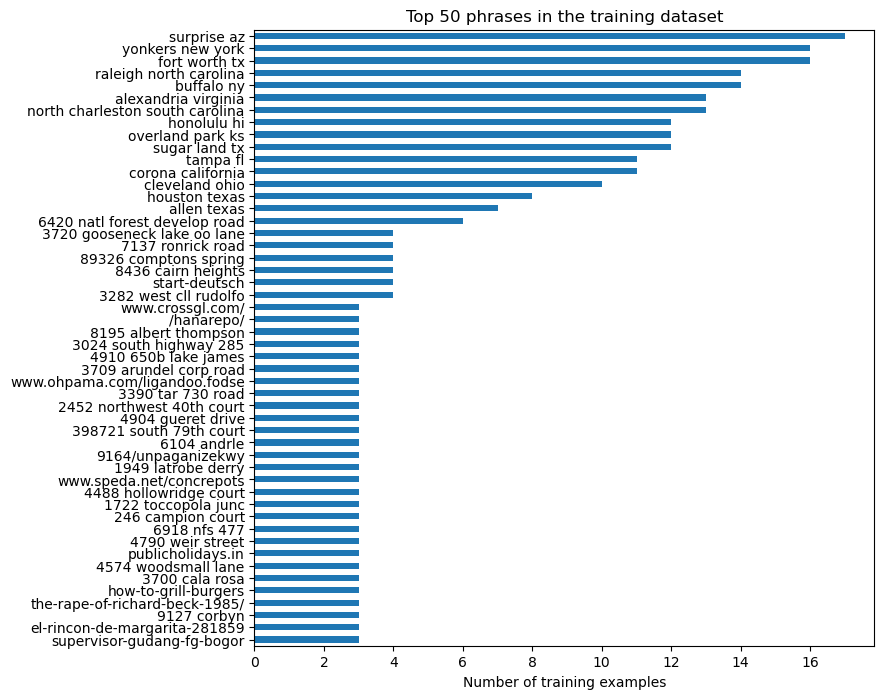

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
train['phrase'].value_counts().head(50).sort_values(ascending=True).plot(
    kind='barh', ax=ax, title = 'Top 50 phrases in the training dataset')
ax.set_xlabel('Number of training examples')
plt.show()

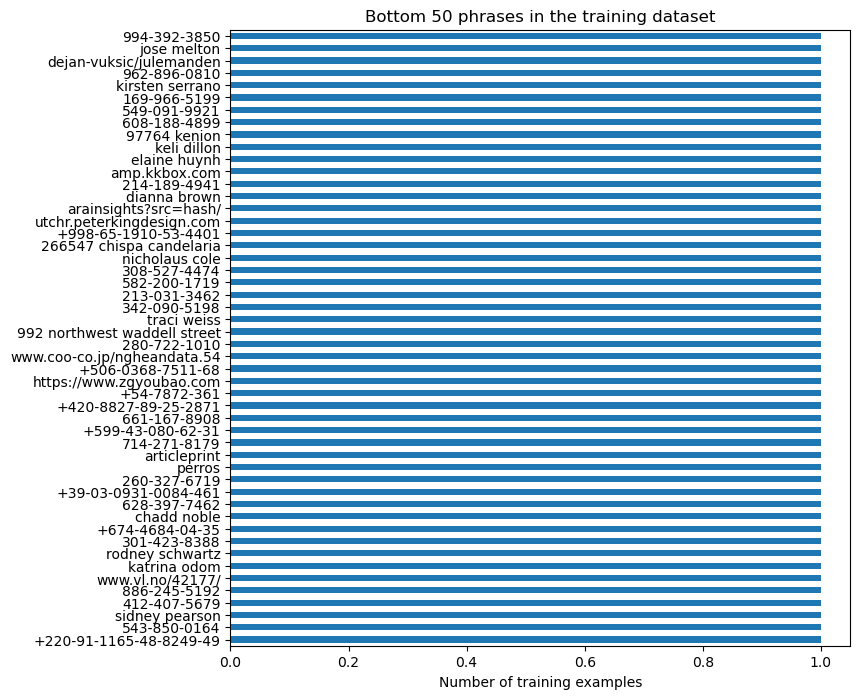

In [10]:
fig, ax = plt.subplots(figsize = (8,8))
train['phrase'].value_counts().tail(50).sort_values(ascending=True).plot(
    kind='barh', ax=ax, title = 'Bottom 50 phrases in the training dataset')
ax.set_xlabel('Number of training examples')
plt.show()

# Pull an example parquet file data
We pull an example landmark file for the phrase "surprise az"

In [13]:
example_fn = train.query('sequence_id == 1816796431')['path'].values[0]
example_landmark = pd.read_parquet(f'{BASE_DIR}/{example_fn}')

In [14]:
example_landmark.shape

(162699, 1630)

In [15]:
example_landmark.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816796431   0.701980  0.709724  0.610405  0.712660  ...        -0.245855   
1816796431   0.700467  0.709796  0.616540  0.713729  ...              NaN   
1816796431   0.703319  0.711549  0.615606  0.715143  ...              NaN   
1816796431   0.704794  0.712483  0.625044  0.715677  ...        -0.370770   
1816796431   0.706928  0.712685  0.614356  0.714875  ...              NaN   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1816796431         -0.269148        -0.129743        -0.251501   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.408097        -0.185217        -0.325494   
1816796431               NaN              NaN              NaN   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1816796431         -0.278687        -0.266530        -0.152852   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.343373        -0.328294        -0.203126   
1816796431               NaN              NaN              NaN   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1816796431         -0.257519        -0.275822        -0.266876  
1816796431               NaN              NaN              NaN  
1816796431               NaN              NaN              NaN  
1816796431         -0.315719        -0.326104        -0.314282  
1816796431               NaN              NaN              NaN  

[5 rows x 1630 columns]

In [16]:
example_landmark['frame'].value_counts()

0      1000
1       997
2       996
3       994
4       994
       ... 
611       1
610       1
609       1
608       1
671       1
Name: frame, Length: 672, dtype: int64

Each 'sequence_id' corresponds to a single phrase.

## Let's vusualize the phrase "surprise az":

In [17]:
target_phrase = example_landmark.loc[train.query('phrase == "3 creekhouse"')['sequence_id'].values[0]]
target_phrase.shape

(123, 1630)

In [18]:
target_phrase.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816796431   0.701980  0.709724  0.610405  0.712660  ...        -0.245855   
1816796431   0.700467  0.709796  0.616540  0.713729  ...              NaN   
1816796431   0.703319  0.711549  0.615606  0.715143  ...              NaN   
1816796431   0.704794  0.712483  0.625044  0.715677  ...        -0.370770   
1816796431   0.706928  0.712685  0.614356  0.714875  ...              NaN   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1816796431         -0.269148        -0.129743        -0.251501   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.408097        -0.185217        -0.325494   
1816796431               NaN              NaN              NaN   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1816796431         -0.278687        -0.266530        -0.152852   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.343373        -0.328294        -0.203126   
1816796431               NaN              NaN              NaN   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1816796431         -0.257519        -0.275822        -0.266876  
1816796431               NaN              NaN              NaN  
1816796431               NaN              NaN              NaN  
1816796431         -0.315719        -0.326104        -0.314282  
1816796431               NaN              NaN              NaN  

[5 rows x 1630 columns]

In [20]:
phrase_string = train.loc[train["sequence_id"] == 1816796431].phrase.values[0]
phrase_string

'3 creekhouse'

The following code was taken from this [notebook](http://https://www.kaggle.com/code/sharifi76/eda-motion-visualization-fingerspelling)

In [21]:
def map_new_to_old_style(sequence):
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)

# assign desired colors to landmarks
def assign_color(row):
    if row == 'face':
        return 'red'
    elif 'hand' in row:
        return 'dodgerblue'
    else:
        return 'green'

# specifies the plotting order
def assign_order(row):
    if row.type == 'face':
        return row.landmark_index + 101
    elif row.type == 'pose':
        return row.landmark_index + 30
    elif row.type == 'left_hand':
        return row.landmark_index + 80
    else:
        return row.landmark_index
    
def visualise2d_landmarks(parquet_df, title="",inter_frame_delay : int = 100):
    connections = [  
        [0, 1, 2, 3, 4,],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],

        
        [38, 36, 35, 34, 30, 31, 32, 33, 37],
        [40, 39],
        [52, 46, 50, 48, 46, 44, 42, 41, 43, 45, 47, 49, 45, 51],
        [42, 54, 56, 58, 60, 62, 58],
        [41, 53, 55, 57, 59, 61, 57],
        [54, 53],

        
        [80, 81, 82, 83, 84, ],
        [80, 85, 86, 87, 88],
        [80, 89, 90, 91, 92],
        [80, 93, 94, 95, 96],
        [80, 97, 98, 99, 100], ]

    parquet_df = map_new_to_old_style(parquet_df)
    frames = sorted(set(parquet_df.frame))
    first_frame = min(frames)
    parquet_df['color'] = parquet_df.type.apply(lambda row: assign_color(row))
    parquet_df['plot_order'] = parquet_df.apply(lambda row: assign_order(row), axis=1)
    first_frame_df = parquet_df[parquet_df.frame == first_frame].copy()
    first_frame_df = first_frame_df.sort_values(["plot_order"]).set_index('plot_order')


    frames_l = []
    for frame in frames:
        filtered_df = parquet_df[parquet_df.frame == frame].copy()
        filtered_df = filtered_df.sort_values(["plot_order"]).set_index("plot_order")
        traces = [go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=filtered_df.color,
                size=9))]

        for i, seg in enumerate(connections):
            trace = go.Scatter(
                    x=filtered_df.loc[seg]['x'],
                    y=filtered_df.loc[seg]['y'],
                    mode='lines',
            )
            traces.append(trace)
        frame_data = go.Frame(data=traces, traces = [i for i in range(17)])
        frames_l.append(frame_data)

    traces = [go.Scatter(
        x=first_frame_df['x'],
        y=first_frame_df['y'],
        mode='markers',
        marker=dict(
            color=first_frame_df.color,
            size=9
        )
    )]
    for i, seg in enumerate(connections):
        trace = go.Scatter(
            x=first_frame_df.loc[seg]['x'],
            y=first_frame_df.loc[seg]['y'],
            mode='lines',
            line=dict(
                color='black',
                width=2
            )
        )
        traces.append(trace)
    
    fig = go.Figure(
            data=traces,
            frames=frames_l
        )

    fig.update_layout(
        width=500,
        height=800,
        scene={
            'aspectmode': 'data',
        },
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": inter_frame_delay,
                                                  "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {"duration": 0}}],
                        "label": "&#9654;",
                        "method": "animate",
                    },
                    {
                        "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                          "mode": "immediate",
                                          "transition": {"duration": 0}}],
                        "label": "&#9612;&#9612;",
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 100, "t": 100},
                "font": {"size":20},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
    )
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        eye=dict(x=0, y=0, z=2.5)
    )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_layout(scene_camera=camera, showlegend=False)
    fig.update_layout(xaxis = dict(visible=False),
            yaxis = dict(visible=False),
    )
    fig.update_yaxes(autorange="reversed")

    fig.show()
    
    
def get_phrase(df, file_id, sequence_id):
    return df[
        np.logical_and(
            df.file_id == file_id, 
            df.sequence_id == sequence_id
        )
    ].phrase.iloc[0]

In [22]:
visualise2d_landmarks(target_phrase, f"Phrase: {phrase_string}", inter_frame_delay=200)

### Let’s do an experiment to see how much the phrase visualization changes if we fill the null spaces with the value 0

In [24]:
target_phraseP = example_landmark.loc[1816796431]
target_phraseP.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816796431   0.701980  0.709724  0.610405  0.712660  ...        -0.245855   
1816796431   0.700467  0.709796  0.616540  0.713729  ...              NaN   
1816796431   0.703319  0.711549  0.615606  0.715143  ...              NaN   
1816796431   0.704794  0.712483  0.625044  0.715677  ...        -0.370770   
1816796431   0.706928  0.712685  0.614356  0.714875  ...              NaN   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1816796431         -0.269148        -0.129743        -0.251501   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.408097        -0.185217        -0.325494   
1816796431               NaN              NaN              NaN   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1816796431         -0.278687        -0.266530        -0.152852   
1816796431               NaN              NaN              NaN   
1816796431               NaN              NaN              NaN   
1816796431         -0.343373        -0.328294        -0.203126   
1816796431               NaN              NaN              NaN   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1816796431         -0.257519        -0.275822        -0.266876  
1816796431               NaN              NaN              NaN  
1816796431               NaN              NaN              NaN  
1816796431         -0.315719        -0.326104        -0.314282  
1816796431               NaN              NaN              NaN  

[5 rows x 1630 columns]

In [25]:
target_phrase_fill = target_phraseP.fillna(0)

In [20]:
target_phrase_fill.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816796431   0.701980  0.709724  0.610405  0.712660  ...        -0.245855   
1816796431   0.700467  0.709796  0.616540  0.713729  ...         0.000000   
1816796431   0.703319  0.711549  0.615606  0.715143  ...         0.000000   
1816796431   0.704794  0.712483  0.625044  0.715677  ...        -0.370770   
1816796431   0.706928  0.712685  0.614356  0.714875  ...         0.000000   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1816796431         -0.269148        -0.129743        -0.251501   
1816796431          0.000000         0.000000         0.000000   
1816796431          0.000000         0.000000         0.000000   
1816796431         -0.408097        -0.185217        -0.325494   
1816796431          0.000000         0.000000         0.000000   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1816796431         -0.278687        -0.266530        -0.152852   
1816796431          0.000000         0.000000         0.000000   
1816796431          0.000000         0.000000         0.000000   
1816796431         -0.343373        -0.328294        -0.203126   
1816796431          0.000000         0.000000         0.000000   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1816796431         -0.257519        -0.275822        -0.266876  
1816796431          0.000000         0.000000         0.000000  
1816796431          0.000000         0.000000         0.000000  
1816796431         -0.315719        -0.326104        -0.314282  
1816796431          0.000000         0.000000         0.000000  

[5 rows x 1630 columns]

In [26]:
visualise2d_landmarks(target_phrase_fill, f"Phrase: {phrase_string}", inter_frame_delay=200)

Through testing a single phrase, it was observed that the phrase's visualization is less disrupted when the null spaces are filled with the value zero.

### Preparing a phrase and its data for use as input in an RNN model
We will prepare the data of the phrase "3 cheeckhouse" to be analyzed

- **Separate the coordinate columns (x, y, z) by landmark type (face, left_hand, right_hand, pose) into separate arrays.**

In [22]:
# Get the columns corresponding to the face landmarks (face)
face_columns = [col for col in target_phrase_fill.columns if col.startswith('x_face') or col.startswith('y_face') or col.startswith('z_face')]
face_landmarks = target_phrase_fill[face_columns].values

# Get the columns corresponding to the pose landmarks (left_hand)
pose_columns = [col for col in target_phrase_fill.columns if col.startswith('x_pose') or col.startswith('y_pose') or col.startswith('z_pose')]
pose_landmarks = target_phrase_fill[pose_columns].values

# Get the columns corresponding to the left hand landmarks (left_hand)
left_hand_columns = [col for col in target_phrase_fill.columns if col.startswith('x_left_hand') or col.startswith('y_left_hand') or col.startswith('z_left_hand')]
left_hand_landmarks = target_phrase_fill[left_hand_columns].values

# Get the columns corresponding to the right hand landmarks(right_hand)
right_hand_columns = [col for col in target_phrase_fill.columns if col.startswith('x_right_hand') or col.startswith('y_right_hand') or col.startswith('z_right_hand')]
right_hand_landmarks = target_phrase_fill[right_hand_columns].values

In [24]:
face_landmarks.shape

(123, 1404)

In [33]:
pose_landmarks.shape

(123, 99)

In [26]:
left_hand_landmarks.shape

(123, 63)

In [34]:
right_hand_landmarks.shape

(123, 63)

- **Group the coordinates of the different types of landmark into sequences according to the frame (frame) and the type of landmark. This means that each sequence will contain a set of coordinates (x, y, z) for a specific landmark type in a given frame.**

In [68]:
target_phrase_fill['frame'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122], dtype=int16)

In [69]:
target_phrase_fill['frame'].value_counts()

0      1
92     1
90     1
89     1
88     1
      ..
36     1
35     1
34     1
33     1
122    1
Name: frame, Length: 123, dtype: int64

In [70]:
# Get the total number of frames in the dataframe
num_frames = len(target_phrase_fill['frame'].unique())

# Create a dictionary to store sequences grouped by frame and landmark type
sequences = {}

# Iterate through each frame and landmark type to group the coordinates into sequences.
for frame in range(num_frames):
    # Groups face coordinates for the current frame
    face_sequence = face_landmarks[target_phrase_fill['frame'] == frame]
    
    # Groups pose coordinates for the current frame
    pose_sequence = pose_landmarks[target_phrase_fill['frame'] == frame]

    # Groups the coordinates of the left hand for the current frame
    left_hand_sequence = left_hand_landmarks[target_phrase_fill['frame'] == frame]

    # Groups the coordinates of the right hand for the current frame
    right_hand_sequence = right_hand_landmarks[target_phrase_fill['frame'] == frame]

    # Stores sequences in the dictionary using the frame as key
    sequences[frame] = {
        'face': face_sequence,
        'pose': pose_sequence,
        'left_hand': left_hand_sequence,
        'right_hand': right_hand_sequence
    }

# Prints the resulting sequences
for frame, landmark_sequences in sequences.items():
    print("Frame:", frame)
    print("Face Landmarks:")
    print(landmark_sequences['face'])
    print("Pose Landmarks:")
    print(landmark_sequences['pose'])
    print("Left Hand Landmarks:")
    print(landmark_sequences['left_hand'])
    print("Right Hand Landmarks:")
    print(landmark_sequences['right_hand'])
    print()

Frame: 0
Face Landmarks:
[[ 0.7105884   0.6999506   0.7056565  ... -0.00141129  0.01722278
   0.01751241]]
Pose Landmarks:
[[ 0.71401465  0.7742717   0.807475    0.83493096  0.6773103   0.6502809
   0.6262915   0.88290364  0.60132205  0.78712     0.6702331   1.1212175
   0.4436932   1.2630097   0.19657199  1.2266585   0.36474448  1.2540009
   0.42470288  1.169468    0.46171424  1.1343181   0.47083145  0.9165736
   0.43882036  0.8045942   0.3695557   0.7376537   0.34809825  0.7555017
   0.3401024   0.6716488   0.36256787  0.51229113  0.46382532  0.4648035
   0.46647936  0.4644362   0.4659583   0.46836582  0.48696396  0.49179092
   0.5607643   0.5625761   0.7313763   0.69460666  1.0567002   1.0024331
   1.3033774   0.8417101   1.3959467   0.7901854   1.3782227   0.7443211
   1.343307    0.7710637   1.2729068   1.2468874   1.7094486   1.6909008
   2.089854    2.0718248   2.1498497   2.123824    2.2170532   2.2173297
  -2.2438369  -2.1490889  -2.1496556  -2.1499867  -2.1220217  -2.1211483


- **Encode the label or phrase "3 cheekhouse" in a numerical representation suitable for the model. You can use techniques like one-hot encoding or tokenization to convert the phrase into a vector representation.**

In [35]:
# Cargar el archivo JSON
with open(f'{BASE_DIR}/character_to_prediction_index.json', "r") as f:
    char_to_index = json.load(f)

# Función para codificar una frase en forma numérica
def encode_sentence(sentence, char_to_index):
    encoded_sentence = []
    for char in sentence:
        encoded_sentence.append(char_to_index.get(char, -1))
    return encoded_sentence

# Ejemplo de uso
sentence = "3 cheeckhouse"
encoded_sentence = encode_sentence(sentence, char_to_index)
print(encoded_sentence)



[18, 0, 34, 39, 36, 36, 34, 42, 39, 46, 52, 50, 36]


## **Prepare the data for training**
The plan entails utilizing a deep learning model, specifically a recurrent neural network (RNN). RNNs excel at processing sequences of varying lengths and capturing temporal information within the data. In our case, the input to the model will consist of sequences of landmarks corresponding to each phrase. As demonstrated earlier, these phrase-specific landmark sequences can vary in length.

## Evaluation
The evaluation metric for this contest is the normalized total levenshtein distance. Let the total number of characters in the labels be N and the total levenshtein distance be D. The metric equals (N - D) / N.

In [ ]:
def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=selected_columns)

In [11]:
import tflite_runtime.interpreter as tflite
​
def run_model(model_path):
    interpreter = tflite.Interpreter(model_path)
​
​
    with open ("/kaggle/input/fingerspelling-character-map/character_to_prediction_index.json", "r") as f:
        character_map = json.load(f)
    rev_character_map = {j:i for i,j in character_map.items()}
​
    found_signatures = list(interpreter.get_signature_list().keys())
​
    if REQUIRED_SIGNATURE not in found_signatures:
        raise KernelEvalException('Required input signature not found.')
​
    prediction_fn = interpreter.get_signature_runner("serving_default")
    output = prediction_fn(inputs=frames)
    prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])

SyntaxError: invalid non-printable character U+200B (3586949990.py, line 2)